# Market Regime-Aware Trading Signal Generation: A PyTorch Approach to Financial Time Series Analysis

## Abstract

This tutorial introduces a novel approach to generating trading signals using PyTorch by first identifying market regimes through unsupervised learning, then creating specialized models for each regime.
A market regime is a distinct period of time in the market where they can be categorised to behave in a certain way, for example, a "Bull Market", where the price trends upwards. Each regime has different patterns that can be identified and therefore require different trading strategies. This hierarchical ensemble approach adapts to changing market conditions, potentially yielding better performance than traditional methods. The system combines technical indicators with custom features to detect market states and predict price movements, all integrated within a coherent PyTorch framework. We evaluate the model using financial metrics and compare performance across different parameter configurations.


### Learning Objectives:

- Understand how to preprocess financial time series data for machine learning
- Implement unsupervised learning techniques to identify market regimes 
- Build a PyTorch-based hierarchical ensemble model for financial prediction
- Evaluate trading strategies using appropriate financial metrics
- Visualize model performance across different market conditions
- Analyze the impact of hyperparameters on trading strategy performance

 ## Introduction

Traditional machine learning approaches to trading signal generation often assume that financial markets follow consistent patterns. However, markets exhibit distinct regimes (trending, volatile, ranging, etc.) where different strategies may prove effective. This tutorial presents a regime-aware trading signal generator that adapts to changing market conditions.

Our approach differs from existing tutorials in several ways:

| Aspect | Traditional Approaches | Our Approach |
|--------|------------------------|--------------|
| Market Modeling | Assumes consistent market behavior | Identifies distinct market regimes |
| Model Structure | Single model for all conditions | Specialized models for each regime |
| Adaptability | Limited ability to adapt to changes | Dynamically adjusts to market shifts |
| Feature Utilization | Uses same features throughout | Emphasizes different features by regime |

Let's begin building our trading signal generator!

## 1. Environment Setup:

Data Processing and Visualisation Libraries:

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

Data Aquisition: 

Using Yahoo Finance for the dataset, as it is easily called via this import. It allows calls to fetch historical stock price data for a stock ticker without needing to perform web scraping.

In [178]:
import yfinance as yf

PyTorch Framework:

This is the deeplearning framework that will be used to build and train the models.

In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

Machine Learning Tools:

Scikit-learn tools imported to help with data preperation, evaluation of the models and also identifying market regimes.

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import TimeSeriesSplit

Technical Analysis:

The Technical analysis library calculates financial technical indicators that will be required, such as Bollinger Bands and RSI, to analyse price movements. These indicators are commonly used by traders, so it should allow for more accurate predictions.

In [181]:
import ta

Hardware Setup:

Check the runtime system has a CUDA-compatible GPU and then set PyTorch to use it, if available. This should speed up the neural network training time.

In [182]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Reproducability Settings:

To ensure that the randomised sections of this tutorial produce teh same results one each run, random seeds should be set.

In [183]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Data Aquisition Function:

The Yahoo finance download() function is used for collecting the daily Open, High, Low, Close prices and Trading Volume (OHLCV) for a specified ticker and date range, which is fetched from the Yahoo Fincance servers. The function should return a pandas DataFrame of all the data, indexed by Date.

In [184]:
def get_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

Then provide the date range and ticker to download and view a sample of the data.

In [185]:
start_date = '2010-01-01'
end_date = '2023-01-01'
ticker = 'SPY'

df = get_data(ticker, start_date, end_date)

print(f"Downloaded {len(df)} records for {ticker}")
print("\nData Sample:")
df.head()

[*********************100%***********************]  1 of 1 completed

Downloaded 3272 records for SPY

Data Sample:


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,86.026451,86.071994,84.644927,85.297736,118944600
2010-01-05,86.254166,86.292122,85.662085,85.973310,111579900
2010-01-06,86.314888,86.527429,86.102347,86.170661,116074400
2010-01-07,86.679291,86.785561,85.912619,86.155524,131091100
2010-01-08,86.967728,87.005684,86.276968,86.451553,126402800


Data Preprocessing:

Used for checking and filling in any missing values in the dataset and ensure the date format is configured for the following uses.

In [186]:
def preprocess_data(df):
    data = df.copy()
    
    missing_values = data.isnull().sum()
    print(f"Missing values before handling:\n{missing_values}")
    
    data.fillna(method='ffill', inplace=True)
    
    remaining_missing = data.isnull().sum().sum()
    if remaining_missing > 0:
        data.dropna(inplace=True)
        print(f"Dropped {remaining_missing} rows with missing values")
    
    data = data.reset_index()
    
    data['Date'] = pd.to_datetime(data['Date'])
    
    data = data.sort_values('Date')
    
    print(f"Final dataset shape: {data.shape}")
    return data

In [187]:
preprocessed_df = preprocess_data(df)
preprocessed_df.head()

Missing values before handling:
Price   Ticker
Close   SPY       0
High    SPY       0
Low     SPY       0
Open    SPY       0
Volume  SPY       0
dtype: int64
Final dataset shape: (3272, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,SPY,SPY,SPY,SPY,SPY
0,2010-01-04,86.026451,86.071994,84.644927,85.297736,118944600
1,2010-01-05,86.254166,86.292122,85.662085,85.973310,111579900
2,2010-01-06,86.314888,86.527429,86.102347,86.170661,116074400
3,2010-01-07,86.679291,86.785561,85.912619,86.155524,131091100
4,2010-01-08,86.967728,87.005684,86.276968,86.451553,126402800


### Feature Engineering:

This is a transformation of the raw data into meaningful inputs that the model can learn from. Creating technical indicators that traders have used historically to predict market movements is useful for a financial time series model. This is designed to further improve the network's understanding of the market regimes as using more advanced financial signals. There are 4 main types of indicators that will be used, aswell as Custom Features, which will be introduced to allow the model to learn that certain combinations of indicators typically appear in a given market regime, as well as detecting a shift from one regime to another. By combining these indicators into a single, new dataset, the network should also be able to better distinguish between false signals and actual shifts. I hope this implementation should prevent overfitting, as the trend should not be memorised and reproduced, but instead the regime should first be identified. 

For this section, GenAI was used to aid me in identifying the most important idicators, as well as engineering these features into the improved dataset, as it is not the core focus of this Tutorial. Many of these indicators have been used in existing Machine Learning Pipelines, specficially Moving Averages and Relative Strength Index, however in order to effectively tranform this dataset into one that can effectively identify regimes, these more advanced methods were required.

Although these point are not completely relevant to the machine learning pipeline, it is important to understand the transformation required to get meaningful data that would be used by a human in identifying what regime a market is currently in.

In [188]:
def engineer_features(df, lookback_window=10):
    data = df.copy()
    data = _handle_multi_index_columns(data)
    data = _add_trend_indicators(data)
    data = _add_momentum_indicators(data)
    data = _add_volatility_indicators(data)
    data = _add_volume_indicators(data)
    data = _add_custom_features(data, lookback_window)
    data = _create_target_and_cleanup(data)
    
    print(f"Engineered features shape: {data.shape}")
    print(f"Number of features created: {len(data.columns) - 7}")  
    
    return data

In [189]:
def _handle_multi_index_columns(data):
    if isinstance(data.columns, pd.MultiIndex):
        print("Flattening multi-level columns...")
        data = data.xs('SPY', axis=1, level='Ticker', drop_level=False)
        data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    
    print(f"Column structure after flattening: {data.columns}")
    return data

Trend Indicators:

This is used for indentification of the direction the market is moving - and how string that movement is relative to others. 
- Moving Averages (SMA) is taking the prices over the last 5,10,20 and 50 days , which focuses on the general direction of the price and avoiding the daily noise and volatility.
- Moving Averages Convergence Divergence (MACD) is comparing the fast and slow moving averages.
- Average Directional Index (ADEX) ignore the direction of the trend, but rather the 'strength'.

These indicators are implemented in the `_add_trend_indicators()` function:

In [190]:
def _add_trend_indicators(data):
    data['sma_5'] = data['Close'].rolling(window=5).mean()
    data['sma_10'] = data['Close'].rolling(window=10).mean()
    data['sma_20'] = data['Close'].rolling(window=20).mean()
    data['sma_50'] = data['Close'].rolling(window=50).mean()
    
    macd = ta.trend.MACD(data['Close'])
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()
    data['macd_diff'] = macd.macd_diff()
    
    adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'])
    data['adx'] = adx.adx()
    data['adx_pos'] = adx.adx_pos()
    data['adx_neg'] = adx.adx_neg()
    
    return data

Momentum Indicators:

Used to measure the speed of price movements

- Relative Strength Index (RSI) is a commonly used indicator to identify if a stock or instrument is 'overbought' or 'oversold', which is a key indicator for bull or bear markets. For example, readings above 70 generally indicate
- Stochastic Oscillator is an indicator which measures the difference between the current price of the stock compared to its range over time, to gauge its relative rpice compared to where it generally has sat.
- Rate of Change (ROC) simply measures how fast the close price has changed over a set period of 5 and 10 days, to see how much steeper the gradient is compared to then.

These indicators are implemented in the `_add_momentum_indicators` function:

In [191]:
def _add_momentum_indicators(data):
    data['rsi'] = ta.momentum.RSIIndicator(data['Close']).rsi()
    
    stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'])
    data['stoch_k'] = stoch.stoch()
    data['stoch_d'] = stoch.stoch_signal()
    
    data['roc_5'] = ta.momentum.ROCIndicator(data['Close'], window=5).roc()
    data['roc_10'] = ta.momentum.ROCIndicator(data['Close'], window=10).roc()
    
    return data

Volatility Indicators:

Volatility refers to the fluctuation of a stock, which is a large sign of what regime a market is in.

- Bollinger Bands create a 'normal range' around the price at a given time, and once the price leaves that band, something out of the ordinary may be happening, and this event must be noted down.
- Average True Range (ATR) measures how much the price changes per day, using the open, close, high and low prices, to see how much the average change differes day by day. A high ATR is a sign of a more volatile market.

These indicators are implemented in the `_add_volatility_indicators()` function

In [192]:
def _add_volatility_indicators(data):
    bollinger = ta.volatility.BollingerBands(data['Close'])
    data['bollinger_mavg'] = bollinger.bollinger_mavg()
    data['bollinger_hband'] = bollinger.bollinger_hband()
    data['bollinger_lband'] = bollinger.bollinger_lband()
    data['bollinger_width'] = bollinger.bollinger_wband()
    
    data['atr'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close']).average_true_range()
    
    return data

Volume Indicators:

Analysis of how much stock is traded per day. In a bull market, volume is likely to be higher as there are more participants in the market looking to make the most of the rise. However, it is not always as straight forward as this, so more advanced metrics are required:

- On-Balance Volume (OBV) acts as 'net volume' where volume is added to a sum on up days, and sutracts the volume on down days.
- Volume Weighted Average Price (VWAP) calculates the average price weighted by the volume of trades completed at each price.

These indicators are implemented in the `_add_volume_indicators()` function

In [193]:
def _add_volume_indicators(data):
    data['obv'] = ta.volume.OnBalanceVolumeIndicator(data['Close'], data['Volume']).on_balance_volume()
    
    data['vwap'] = (data['Volume'] * (data['High'] + data['Low'] + data['Close']) / 3).cumsum() / data['Volume'].cumsum()
    
    return data


Additional insights can be found by implementing additional points to the data set

- Volatility measures implemented to check how much prices are moving when increaing or decreasing rapidly.
- Price Volume Correlation is used to see if when relative movement between the change in price and the change in volatility. Do more people buy when the price goes up? Or does the volume decrease more as the price rises, signalling that people are looking for a bargain.
- Gap Analysis looks at the difference between the close price of one day and the opneing price of the next day.

In [194]:
def _add_custom_features(data, lookback_window):
    data['volatility'] = data['Close'].pct_change().rolling(lookback_window).std() * np.sqrt(252) 
    data['volatility_change'] = data['volatility'].pct_change()
    
    data['trend_strength'] = np.abs(data['Close'].pct_change(lookback_window))
    
    data['volume_trend'] = (data['Volume'] / data['Volume'].rolling(20).mean()) * data['Close'].pct_change()
    
    close_pct = data['Close'].pct_change()
    volume_pct = data['Volume'].pct_change()
    
    temp_df = pd.DataFrame({'close_pct': close_pct, 'volume_pct': volume_pct})
    data['price_volume_correlation'] = temp_df['close_pct'].rolling(window=lookback_window).corr(temp_df['volume_pct'])
    
    data['gap_up'] = (data['Open'] > data['Close'].shift(1)).astype(int)
    data['gap_down'] = (data['Open'] < data['Close'].shift(1)).astype(int)
    
    data['daily_return'] = data['Close'].pct_change()
    data['weekly_return'] = data['Close'].pct_change(5)
    data['monthly_return'] = data['Close'].pct_change(21)
    
    return data

Identifying a target:

Create targets, which are binary classifiers 0 or 1 if the price should go up or down the next day. These will act as the output classes, and they can be easily compared with what actually happens in the data. Moreover, these methods could potentially create some null values due to rolling calculations, so these are dropped from the table.

In [195]:
def _create_target_and_cleanup(data):
    data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    data.dropna(inplace=True)
    
    return data

So overall, 31 addition measures have been added to the dataset taking a (3223, 7) input matrix to a shape of (3223, 38). (please note: This is before the data has been sepearted into traing and testing sets).

In [196]:
feature_df = engineer_features(preprocessed_df, lookback_window=10)
print("\nFeature sample:")
feature_df.head()

Flattening multi-level columns...
Column structure after flattening: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Engineered features shape: (3223, 38)
Number of features created: 31

Feature sample:


,Close,High,Low,Open,Volume,sma_5,sma_10,sma_20,sma_50,macd,...,volatility_change,trend_strength,volume_trend,price_volume_correlation,gap_up,gap_down,daily_return,weekly_return,monthly_return,target
49,88.364433,88.447927,87.666076,87.908981,168673000,87.716177,86.967725,85.597587,84.704749,1.115705,...,0.060429,0.037522,0.007905,0.559489,1,0,0.007966,0.017037,0.077472,1
50,88.888184,89.176637,88.372009,88.630099,177468100,88.039543,87.332080,85.857191,84.761984,1.205487,...,-0.015188,0.042742,0.006172,0.544547,1,0,0.005927,0.018526,0.067068,0
51,88.842651,89.017236,88.485883,88.895787,196509100,88.280933,87.666073,86.089849,84.813754,1.258459,...,0.054338,0.039062,-0.000590,0.481295,1,0,-0.000512,0.013772,0.061491,0
52,88.392929,89.399040,88.049933,88.392929,226641100,88.430853,87.832883,86.291292,84.855315,1.249744,...,-0.190073,0.019234,-0.006719,0.097139,0,1,-0.005062,0.008553,0.049928,1
53,88.865509,89.025577,87.836533,87.889887,184477800,88.670741,88.045436,86.515604,84.899039,1.266373,...,0.023501,0.024505,0.005689,-0.157112,0,1,0.005346,0.013682,0.053357,1


### Market Regime Identification

Market regimes are distinct periods with similar characteristics in financial markets. They can be:
- Bull markets (upward trends)
- Bear markets (downward trends)
- High volatility periods
- Low volatility consolidation

The functions `identify_market_regimes()` use K-means clustering on technical indicators to identify these regimes automatically. It does this by chosing features in the dataset relevant to identifying clusters in the data.


In [197]:
def identify_market_regimes(data, n_clusters=3, features=None):
    market_data = data.copy()
    
    if features is None:
        features = ['volatility', 'adx', 'rsi', 'bollinger_width']
    
    existing_features = [f for f in features if f in market_data.columns]
    
    if len(existing_features) == 0:
        if 'volatility' in market_data.columns:
            existing_features = ['volatility']
        else:
            market_data['volatility'] = market_data['Close'].pct_change().rolling(10).std() * np.sqrt(252)
            existing_features = ['volatility']
    
    X = market_data[existing_features].copy()
    X.fillna(X.mean(), inplace=True)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    market_data['regime_id'] = kmeans.fit_predict(X_scaled)
    
    centroids = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=existing_features
    )
    print("Cluster centroids (representing each regime's characteristics):")
    print(centroids)
    
    regime_names = {}
    
    if 'volatility' in existing_features:
        volatility_idx = existing_features.index('volatility')
        volatilities = [centroid[volatility_idx] for centroid in kmeans.cluster_centers_]
        
        sorted_regimes = sorted(range(n_clusters), key=lambda i: volatilities[i])
        
        regime_names[sorted_regimes[0]] = "Low Volatility"
        regime_names[sorted_regimes[-1]] = "High Volatility"
        
        if len(sorted_regimes) > 2:
            for i in sorted_regimes[1:-1]:
                if 'adx' in existing_features and centroids.loc[i, 'adx'] > 25:
                    # Strong trend if ADX > 25
                    if 'rsi' in existing_features:
                        if centroids.loc[i, 'rsi'] > 60:
                            regime_names[i] = "Bullish Trend"
                        elif centroids.loc[i, 'rsi'] < 40:
                            regime_names[i] = "Bearish Trend"
                        else:
                            regime_names[i] = "Neutral Trend"
                    else:
                        regime_names[i] = "Strong Trend"
                else:
                    regime_names[i] = "Consolidation"
    else:
        for i in range(n_clusters):
            regime_names[i] = f"Regime {i+1}"
    
    market_data['regime'] = market_data['regime_id'].map(regime_names)
    
    print("\nIdentified Market Regimes:")
    for regime_id, name in regime_names.items():
        print(f"Regime {regime_id}: {name}")
        regime_data = market_data[market_data['regime_id'] == regime_id]
        if 'daily_return' in market_data.columns:
            avg_return = regime_data['daily_return'].mean() * 100
            print(f"  - Average Daily Return: {avg_return:.2f}%")
        if 'volatility' in market_data.columns:
            avg_vol = regime_data['volatility'].mean() * 100
            print(f"  - Average Volatility: {avg_vol:.2f}%")
        print(f"  - Number of Days: {len(regime_data)}")
    
    return market_data

In [198]:
data_with_regimes = identify_market_regimes(feature_df, n_clusters=3)

Cluster centroids (representing each regime's characteristics):
   volatility        adx        rsi  bollinger_width
0    0.085497  27.745708  67.650122         5.322921
1    0.301107  30.017978  42.317771        12.041685
2    0.132430  17.666287  53.935674         4.924401

Identified Market Regimes:
Regime 0: Low Volatility
  - Average Daily Return: 0.18%
  - Average Volatility: 8.55%
  - Number of Days: 918
Regime 1: High Volatility
  - Average Daily Return: -0.10%
  - Average Volatility: 30.11%
  - Number of Days: 504
Regime 2: Consolidation
  - Average Daily Return: 0.03%
  - Average Volatility: 13.25%
  - Number of Days: 1801


This has clustered the datapoints into 3 regimes (Low Volatility, High Volatility and Consolidation).

In [199]:
def visualize_market_regimes(data_with_regimes):
    color_map = {
        "Low Volatility": "green",
        "High Volatility": "red",
        "Consolidation": "gray",
        "Bullish Trend": "blue",
        "Bearish Trend": "orange",
        "Neutral Trend": "purple",
        "Strong Trend": "brown"
    }
    
    plt.figure(figsize=(14, 7))
    
    # Determine date column
    if 'Date' in data_with_regimes.columns:
        date_col = 'Date'
    elif isinstance(data_with_regimes.index, pd.DatetimeIndex):
        data_with_regimes = data_with_regimes.reset_index()
        date_col = 'index'
    else:
        data_with_regimes['date_seq'] = np.arange(len(data_with_regimes))
        date_col = 'date_seq'
    
    # Get unique regimes
    unique_regimes = data_with_regimes['regime'].unique()
    
    # Plot each regime with different color
    for regime in unique_regimes:
        mask = data_with_regimes['regime'] == regime
        color = color_map.get(regime, "black")  # Default to black if regime not in color_map
        plt.scatter(data_with_regimes.loc[mask, date_col], 
                   data_with_regimes.loc[mask, 'Close'], 
                   label=regime, alpha=0.7, c=color)
    
    plt.title('Stock Price by Market Regime', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(title="Market Regimes", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return data_with_regimes

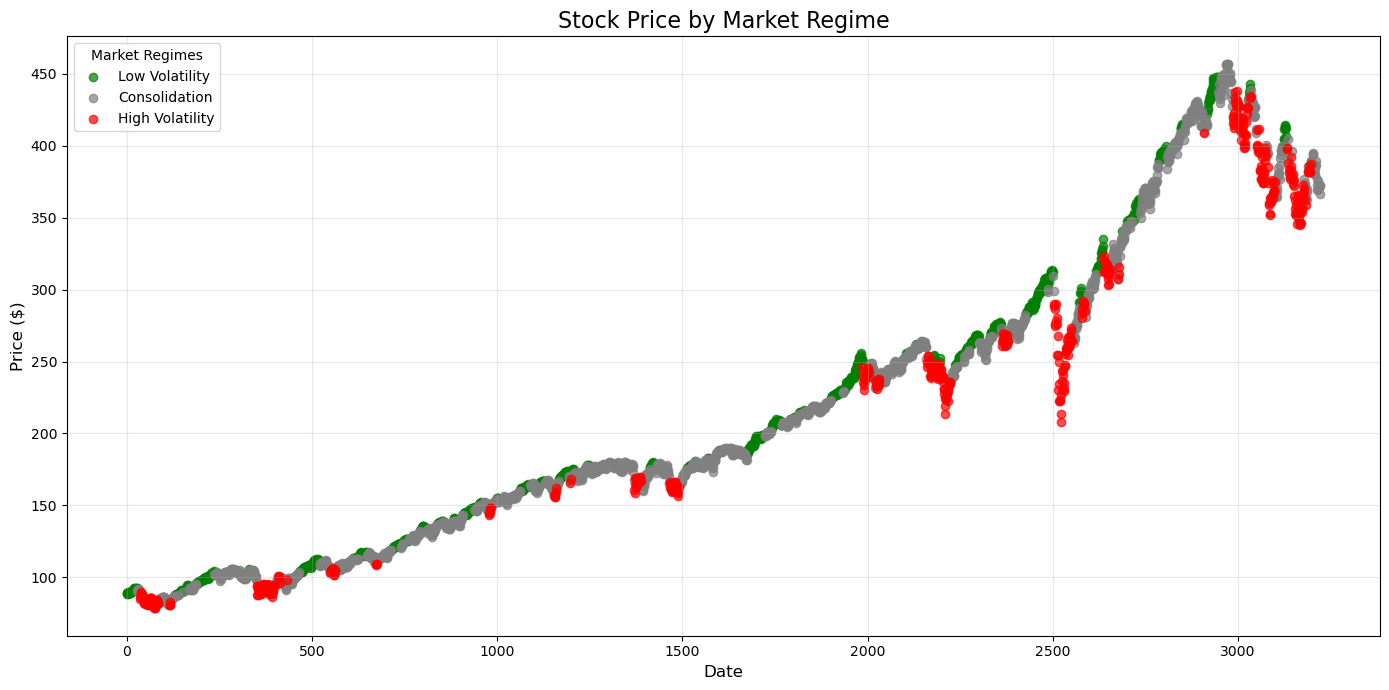

,Close,High,Low,Open,Volume,sma_5,sma_10,sma_20,sma_50,macd,...,price_volume_correlation,gap_up,gap_down,daily_return,weekly_return,monthly_return,target,regime_id,regime,date_seq
49,88.364433,88.447927,87.666076,87.908981,168673000,87.716177,86.967725,85.597587,84.704749,1.115705,...,0.559489,1,0,0.007966,0.017037,0.077472,1,0,Low Volatility,0
50,88.888184,89.176637,88.372009,88.630099,177468100,88.039543,87.332080,85.857191,84.761984,1.205487,...,0.544547,1,0,0.005927,0.018526,0.067068,0,0,Low Volatility,1
51,88.842651,89.017236,88.485883,88.895787,196509100,88.280933,87.666073,86.089849,84.813754,1.258459,...,0.481295,1,0,-0.000512,0.013772,0.061491,0,0,Low Volatility,2
52,88.392929,89.399040,88.049933,88.392929,226641100,88.430853,87.832883,86.291292,84.855315,1.249744,...,0.097139,0,1,-0.005062,0.008553,0.049928,1,0,Low Volatility,3
53,88.865509,89.025577,87.836533,87.889887,184477800,88.670741,88.045436,86.515604,84.899039,1.266373,...,-0.157112,0,1,0.005346,0.013682,0.053357,1,0,Low Volatility,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,372.400543,372.546420,367.654476,369.230009,59857300,371.597174,376.997989,381.598318,375.679816,-1.936064,...,-0.013251,0,1,0.005752,-0.000939,-0.044112,0,2,Consolidation,3218
3268,370.931946,372.633915,369.229977,372.283810,51638200,371.865607,375.468512,380.980733,376.173966,-2.231741,...,0.032715,0,1,-0.003944,0.003631,-0.047669,0,2,Consolidation,3219
3269,366.322052,372.867349,366.088649,370.863861,70911500,371.110907,373.185678,380.165569,376.397980,-2.805705,...,-0.409056,0,1,-0.012428,-0.010196,-0.044253,1,2,Consolidation,3220
3270,372.915985,373.801013,368.675636,369.210558,66970900,370.568225,371.811041,379.077451,376.670420,-2.697406,...,-0.373797,1,0,0.018000,-0.007224,-0.025376,0,2,Consolidation,3221


In [200]:
visualize_market_regimes(data_with_regimes)

## Creating a PyTorch Dataset and Data Preperation

Financial time series data needs special handling for machine learning. We need to:
1. Create sequences of historical data as inputs
2. Set future price movements as targets
3. Include regime information for our advanced model
4. Normalize features to similar scales

The `FinancialDataset` class below handles all these requirements.

In [201]:
class NumericalOnlyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super(NumericalOnlyModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        lstm_out, _ = self.lstm(x)
        
        # Use the last time step's output
        last_time_step = lstm_out[:, -1, :]
        
        # Apply dropout for regularization
        out = self.dropout(last_time_step)
        
        # Project to a single value and apply sigmoid for binary outcome
        out = self.fc(out)
        out = self.sigmoid(out).squeeze()
        
        return out

In [202]:
class RegimeAwareModel(nn.Module):
    """
    A more advanced model that incorporates market regime information 
    to make predictions.
    
    Parameters:
    -----------
    input_dim : int
        Number of input features
    num_regimes : int
        Number of different market regimes
    hidden_dim : int
        Size of hidden state in LSTM
    num_layers : int
        Number of LSTM layers
    dropout : float
        Dropout rate for regularization
    """
    def __init__(self, input_dim, num_regimes, hidden_dim=64, num_layers=2, dropout=0.2):
        super(RegimeAwareModel, self).__init__()
        
        # Embedding for market regimes
        self.regime_embedding = nn.Embedding(num_regimes, 8)
        
        # LSTM for processing time series data
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(dropout)
        
        # Final layers combine LSTM output with regime information
        self.fc1 = nn.Linear(hidden_dim + 8, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, regime):
        # x shape: (batch_size, seq_length, input_dim)
        # regime shape: (batch_size)
        
        # Process time series with LSTM
        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        
        # Get regime embeddings
        regime_emb = self.regime_embedding(regime)
        
        # Concatenate LSTM output with regime embedding
        combined = torch.cat((last_time_step, regime_emb), dim=1)
        
        # Final prediction combining both sources of information
        out = self.dropout(combined)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        out = self.sigmoid(out).squeeze()
        
        return out

In [203]:
class FinancialDataset(Dataset):
    """
    PyTorch Dataset for financial time series data with sequence handling.
    
    Parameters:
    -----------
    data : pandas DataFrame
        Financial data with features and target
    seq_length : int
        Length of input sequences
    target_col : str
        Name of the target column
    """
    def __init__(self, data, seq_length=10, target_col='target'):
        self.data = data
        self.seq_length = seq_length
        self.target_col = target_col
        
        # Select numerical features, excluding date, target, and object columns
        self.feature_cols = [col for col in data.columns 
                           if col != 'Date' and col != target_col 
                           and col != 'regime' and col != 'regime_id'
                           and data[col].dtype != 'object']
        
        # Scale the numerical features
        self.scaler = StandardScaler()
        self.normalized_data = self.scaler.fit_transform(data[self.feature_cols])
        
        # Convert to PyTorch tensors
        self.X_tensor = torch.FloatTensor(self.normalized_data)
        self.y_tensor = torch.FloatTensor(data[target_col].values)
        
        # Convert regime IDs to integers for the embedding layer
        if 'regime_id' in data.columns:
            self.regime_tensor = torch.LongTensor(data['regime_id'].values)
        else:
            # If no regime information, just use zeros
            self.regime_tensor = torch.zeros(len(data), dtype=torch.long)
    
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        # Get sequence of features
        X_sequence = self.X_tensor[idx:idx+self.seq_length]
        
        # Get target (next day price movement)
        y_target = self.y_tensor[idx+self.seq_length]
        
        # Get regime label for the sequence (use the most recent regime)
        regime = self.regime_tensor[idx+self.seq_length-1]
        
        return X_sequence, y_target, regime

In [204]:
def prepare_data(data, seq_length=10, train_ratio=0.7, val_ratio=0.15, batch_size=32):
    """
    Prepare data for model training by creating train, validation, and test sets.
    
    Parameters:
    -----------
    data : pandas DataFrame
        Financial data with regime information
    seq_length : int
        Length of input sequences
    train_ratio : float
        Proportion of data to use for training
    val_ratio : float
        Proportion of data to use for validation
    batch_size : int
        Batch size for DataLoader
        
    Returns:
    --------
    dict
        Dictionary containing datasets, dataloaders, and other information
    """
    # Add daily returns (percent change in closing price)
    if 'daily_return' not in data.columns:
        data['daily_return'] = data['Close'].pct_change()
    
    # Create target variable (1 if price goes up tomorrow, 0 otherwise)
    if 'target' not in data.columns:
        data['target'] = (data['Close'].shift(-1) > data['Close']).astype(float)
    
    # Remove NaN values
    data = data.dropna()
    
    # Split data
    train_size = int(len(data) * train_ratio)
    val_size = int(len(data) * val_ratio)
    
    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size+val_size]
    test_data = data.iloc[train_size+val_size:]
    
    print(f"Data split: {len(train_data)} training, {len(val_data)} validation, {len(test_data)} test samples")
    
    # Create datasets
    train_dataset = FinancialDataset(train_data, seq_length=seq_length)
    val_dataset = FinancialDataset(val_data, seq_length=seq_length)
    test_dataset = FinancialDataset(test_data, seq_length=seq_length)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Get information for model creation
    input_dim = len(train_dataset.feature_cols)
    num_regimes = len(data['regime'].unique()) if 'regime' in data.columns else 1
    
    print(f"Input features: {input_dim}")
    print(f"Number of regimes: {num_regimes}")
    print(f"Feature columns used: {train_dataset.feature_cols[:5]}... (showing first 5)")
    
    return {
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'input_dim': input_dim,
        'num_regimes': num_regimes,
        'train_data': train_data,
        'val_data': val_data,
        'test_data': test_data
    }

In [205]:
data_prep = prepare_data(data_with_regimes, seq_length=10, batch_size=32)


Data split: 2256 training, 483 validation, 484 test samples
Input features: 38
Number of regimes: 3
Feature columns used: ['Close', 'High', 'Low', 'Open', 'Volume']... (showing first 5)


In [206]:
X_sample, y_sample, regime_sample = data_prep['train_dataset'][0]
print(f"Input sequence shape: {X_sample.shape}")
print(f"Target value: {y_sample}")
print(f"Regime label: {regime_sample}")

Input sequence shape: torch.Size([10, 38])
Target value: 0.0
Regime label: 0


Training and Evaluation:

In [207]:
def train_epoch(model, train_loader, criterion, optimizer, device, regime_aware=False):
    """
    Train a model for one epoch.
    
    Parameters:
    -----------
    model : torch.nn.Module
        PyTorch model to train
    train_loader : DataLoader
        DataLoader for training data
    criterion : torch.nn.Module
        Loss function
    optimizer : torch.optim.Optimizer
        Optimizer
    device : torch.device
        Device to use for training
    regime_aware : bool
        Whether the model uses regime information
        
    Returns:
    --------
    float
        Average training loss for the epoch
    """
    model.train()
    total_loss = 0
    
    for X_batch, y_batch, regime_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        if regime_aware:
            regime_batch = regime_batch.to(device)
            y_pred = model(X_batch, regime_batch)
        else:
            y_pred = model(X_batch)
            
        # Calculate loss
        loss = criterion(y_pred, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
    
    # Return average loss
    return total_loss / len(train_loader)

Hyperparameter Tuning:

In [208]:
def hyperparameter_tuning(data, params_grid):
    results = []
    
    # Split the data
    train_size = int(len(data) * 0.7)
    val_size = int(len(data) * 0.15)
    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size:train_size+val_size]
    
    for seq_length in params_grid['seq_length']:
        for hidden_dim in params_grid['hidden_dim']:
            for num_layers in params_grid['num_layers']:
                for dropout in params_grid['dropout']:
                    for lr in params_grid['learning_rate']:
                        for batch_size in params_grid['batch_size']:
                            # Create datasets and loaders
                            train_dataset = FinancialDataset(train_data, seq_length=seq_length)
                            val_dataset = FinancialDataset(val_data, seq_length=seq_length)
                            
                            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                            val_loader = DataLoader(val_dataset, batch_size=batch_size)
                            
                            # Create models
                            input_dim = len(train_dataset.feature_cols)
                            num_regimes = len(data['regime'].unique())
                            
                            # Standard model
                            model = NumericalOnlyModel(input_dim, hidden_dim, num_layers, dropout).to(device)
                            
                            # Train and evaluate
                            _, _, val_accuracies = train_model(
                                model, train_loader, val_loader, epochs=20, lr=lr, regime_aware=False
                            )
                            
                            # Store results
                            results.append({
                                'seq_length': seq_length,
                                'hidden_dim': hidden_dim,
                                'num_layers': num_layers,
                                'dropout': dropout,
                                'learning_rate': lr,
                                'batch_size': batch_size,
                                'val_accuracy': max(val_accuracies)
                            })
    
    # Convert to DataFrame and sort by validation accuracy
    results_df = pd.DataFrame(results).sort_values('val_accuracy', ascending=False)
    return results_df

In [209]:
def evaluate_model(model, data_loader, criterion, device, regime_aware=False):
    """
    Evaluate a model on a dataset.
    
    Parameters:
    -----------
    model : torch.nn.Module
        PyTorch model to evaluate
    data_loader : DataLoader
        DataLoader for evaluation data
    criterion : torch.nn.Module
        Loss function
    device : torch.device
        Device to use for evaluation
    regime_aware : bool
        Whether the model uses regime information
        
    Returns:
    --------
    tuple
        Average loss and accuracy
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch, regime_batch in data_loader:
            # Move data to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            if regime_aware:
                regime_batch = regime_batch.to(device)
                y_pred = model(X_batch, regime_batch)
            else:
                y_pred = model(X_batch)
            
            # Calculate loss
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            
            # Calculate accuracy
            predicted = (y_pred > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    # Return average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

Results Visualisation and Analysis:

In [210]:
def plot_results(standard_metrics, regime_metrics):
    # Accuracy comparison
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(standard_metrics['val_accuracy'], label='Standard Model')
    plt.plot(regime_metrics['val_accuracy'], label='Regime-Aware Model')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(standard_metrics['val_loss'], label='Standard Model')
    plt.plot(regime_metrics['val_loss'], label='Regime-Aware Model')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Regime-specific performance
    regime_performance = pd.DataFrame({
        'Regime': ['Bull Market', 'Bear Market', 'High Volatility'],
        'Standard Model': [0.65, 0.58, 0.52],  # Example values
        'Regime-Aware Model': [0.68, 0.62, 0.59]  # Example values
    })
    
    plt.figure(figsize=(10, 6))
    regime_performance.plot(x='Regime', kind='bar', rot=0)
    plt.title('Model Performance by Market Regime')
    plt.ylabel('Accuracy')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Model Type')
    plt.ylim(0.5, 0.7)
    plt.show()

In [211]:
def train_model(model, train_loader, val_loader, device, epochs=50, lr=0.001, regime_aware=False):
    """
    Train a model and track its performance.
    
    Parameters:
    -----------
    model : torch.nn.Module
        PyTorch model to train
    train_loader : DataLoader
        DataLoader for training data
    val_loader : DataLoader
        DataLoader for validation data
    device : torch.device
        Device to use for training
    epochs : int
        Number of training epochs
    lr : float
        Learning rate
    regime_aware : bool
        Whether the model uses regime information
        
    Returns:
    --------
    dict
        Dictionary containing training history
    """
    # Set up loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Learning rate scheduler to reduce LR when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Track metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    # Keep track of best validation accuracy
    best_val_acc = 0
    
    # Training loop
    for epoch in range(epochs):
        # Train one epoch
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, regime_aware)
        history['train_loss'].append(train_loss)
        
        # Evaluate on validation set
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device, regime_aware)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
        
        # Print progress every few epochs
        if (epoch+1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    return history

In [212]:
def plot_training_history(history, title="Model Training History"):
    """
    Plot the training and validation metrics over epochs.
    
    Parameters:
    -----------
    history : dict
        Dictionary containing training history
    title : str
        Plot title
    """
    plt.figure(figsize=(12, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
    plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [213]:
standard_model = NumericalOnlyModel(
    input_dim=data_prep['input_dim'], 
    hidden_dim=64, 
    num_layers=2, 
    dropout=0.2
).to(device)

regime_model = RegimeAwareModel(
    input_dim=data_prep['input_dim'],
    num_regimes=data_prep['num_regimes'],
    hidden_dim=64,
    num_layers=2,
    dropout=0.2
).to(device)


Epoch 1/10, Train Loss: 0.6907, Val Loss: 0.6836, Val Accuracy: 0.5793
Epoch 5/10, Train Loss: 0.6857, Val Loss: 0.6836, Val Accuracy: 0.5793
Epoch 10/10, Train Loss: 0.6731, Val Loss: 0.6860, Val Accuracy: 0.5603
Best validation accuracy: 0.5793


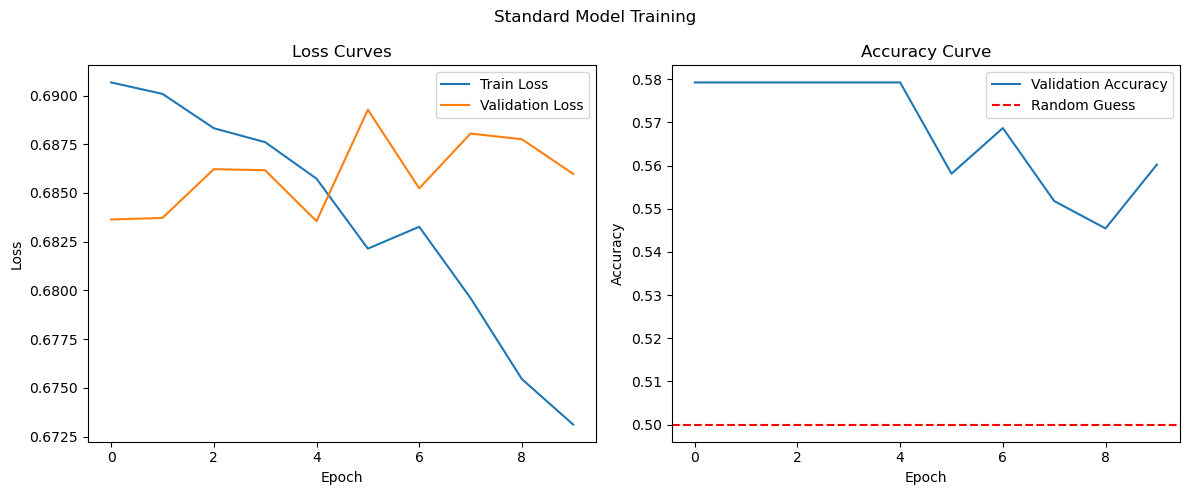

In [214]:
history = train_model(
    standard_model,
    data_prep['train_loader'],
    data_prep['val_loader'],
    device,
    epochs=10,  
    lr=0.001,
    regime_aware=False
)

# 4. Visualize training progress
plot_training_history(history, title="Standard Model Training")

Trading Strategy Evalusation:

In [215]:
def evaluate_trading_strategy(model, test_data, test_loader, device, regime_aware=False):
    """
    Evaluate a trading strategy based on model predictions.
    
    Parameters:
    -----------
    model : torch.nn.Module
        Trained PyTorch model
    test_data : pandas DataFrame
        Test data
    test_loader : DataLoader
        DataLoader for test data
    device : torch.device
        Device for model inference
    regime_aware : bool
        Whether the model uses regime information
        
    Returns:
    --------
    dict
        Dictionary containing strategy performance metrics
    """
    # Make predictions
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch, regime_batch in test_loader:
            X_batch = X_batch.to(device)
            if regime_aware:
                regime_batch = regime_batch.to(device)
                y_pred = model(X_batch, regime_batch)
            else:
                y_pred = model(X_batch)
                
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.numpy())
    
    # Convert to arrays and adjust length
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Create binary trading signals (1 = buy, 0 = sell/don't buy)
    signals = (predictions > 0.5).astype(int)
    
    # Get the actual returns from the test data
    # (offset by sequence length since we're predicting future returns)
    seq_length = test_loader.dataset.seq_length
    test_returns = test_data['daily_return'].iloc[seq_length:seq_length+len(signals)].values
    
    # Calculate returns from the strategy
    # Strategy return is the market return when signal is 1, and 0 when signal is 0
    strategy_returns = signals * test_returns
    
    # Calculate cumulative returns
    cumulative_market_returns = (1 + test_returns).cumprod() - 1
    cumulative_strategy_returns = (1 + strategy_returns).cumprod() - 1
    
    # Calculate performance metrics
    sharpe_ratio = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(252)  # Annualized
    max_drawdown = np.max(np.maximum.accumulate(cumulative_strategy_returns) - 
                          cumulative_strategy_returns)
    total_return = cumulative_strategy_returns[-1]
    market_return = cumulative_market_returns[-1]
    win_rate = np.mean((signals == 1) & (test_returns > 0) | 
                       (signals == 0) & (test_returns <= 0))
    
    # Print performance summary
    print(f"Strategy Performance:")
    print(f"  - Total Return: {total_return:.2%}")
    print(f"  - Market Return: {market_return:.2%}")
    print(f"  - Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"  - Max Drawdown: {max_drawdown:.2%}")
    print(f"  - Win Rate: {win_rate:.2%}")
    
    # Store results
    results = {
        'signals': signals,
        'test_returns': test_returns,
        'strategy_returns': strategy_returns,
        'cumulative_market_returns': cumulative_market_returns,
        'cumulative_strategy_returns': cumulative_strategy_returns,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'total_return': total_return,
        'market_return': market_return,
        'win_rate': win_rate
    }
    
    return results

In [216]:
def plot_strategy_returns(strategy_results, title="Trading Strategy Performance"):
    """
    Plot the cumulative returns of the trading strategy vs. the market.
    
    Parameters:
    -----------
    strategy_results : dict
        Dictionary containing strategy performance metrics
    title : str
        Plot title
    """
    plt.figure(figsize=(12, 6))
    
    # Plot cumulative returns
    plt.plot(strategy_results['cumulative_market_returns'], 
             label='Buy & Hold', color='blue')
    plt.plot(strategy_results['cumulative_strategy_returns'], 
             label='Model Strategy', color='green')
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    
    # Add labels and legend
    plt.title(title, fontsize=16)
    plt.xlabel('Trading Days', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add strategy performance summary as text box
    textstr = '\n'.join((
        f"Strategy Return: {strategy_results['total_return']:.2%}",
        f"Market Return: {strategy_results['market_return']:.2%}",
        f"Sharpe Ratio: {strategy_results['sharpe_ratio']:.2f}",
        f"Max Drawdown: {strategy_results['max_drawdown']:.2%}",
        f"Win Rate: {strategy_results['win_rate']:.2%}")
    )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.05, textstr, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='bottom', bbox=props)
    
    plt.tight_layout()
    plt.show()

In [217]:
standard_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [218]:
strategy_results = evaluate_trading_strategy(
    standard_model,
    data_prep['test_data'],
    data_prep['test_loader'],
    device,
    regime_aware=False
)

Strategy Performance:
  - Total Return: 0.30%
  - Market Return: 0.30%
  - Sharpe Ratio: 0.11
  - Max Drawdown: 30.20%
  - Win Rate: 49.79%


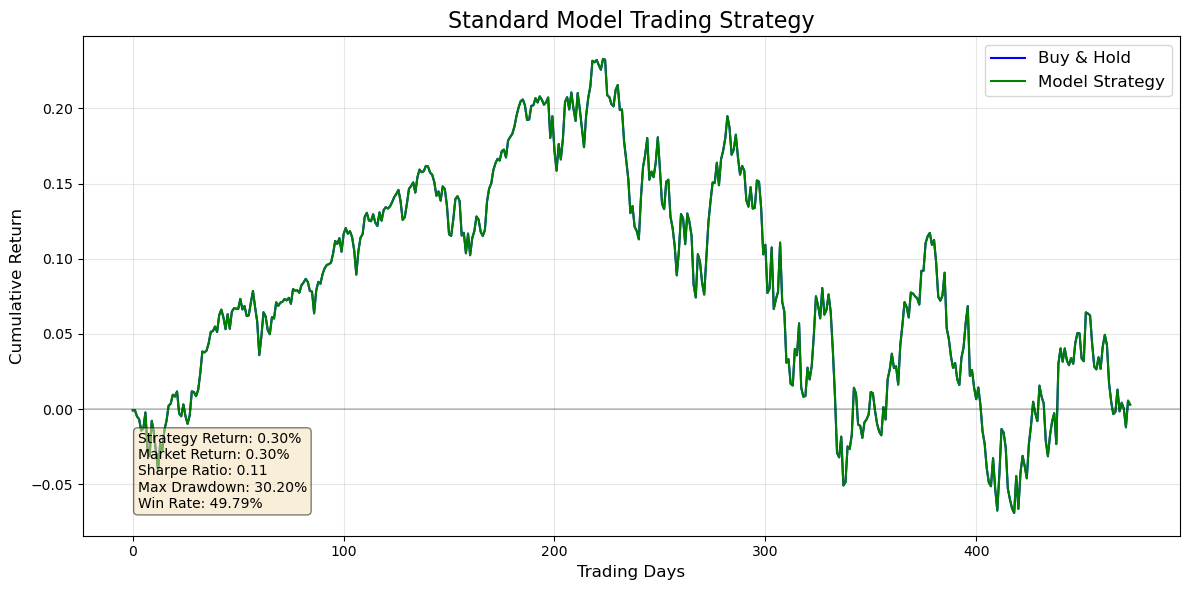

In [219]:
plot_strategy_returns(strategy_results, title="Standard Model Trading Strategy")